In [8]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [14]:
import pandas as pd

df1 = pd.read_csv("/content/drive/MyDrive/pm102022.csv")
df2 = pd.read_csv("/content/drive/MyDrive/pm102023.csv")

df_union = pd.concat([df1, df2], ignore_index=True)

print(df_union.head())


         Date Source   Site ID  POC  Daily Mean PM10 Concentration     Units  \
0  01/01/2022    AQS  10730023    4                             14  ug/m3 SC   
1  01/02/2022    AQS  10730023    4                              7  ug/m3 SC   
2  01/05/2022    AQS  10730023    4                             21  ug/m3 SC   
3  01/06/2022    AQS  10730023    4                             21  ug/m3 SC   
4  01/07/2022    AQS  10730023    4                             13  ug/m3 SC   

   Daily AQI Value   Local Site Name  Daily Obs Count  Percent Complete  ...  \
0               13  North Birmingham                1             100.0  ...   
1                6  North Birmingham                1             100.0  ...   
2               19  North Birmingham                1             100.0  ...   
3               19  North Birmingham                1             100.0  ...   
4               12  North Birmingham                1             100.0  ...   

   AQS Parameter Description Method Co

In [42]:
import pandas as pd

# === 1. Unir datasets ===
df1 = pd.read_csv("/content/drive/MyDrive/pm102022.csv")
df2 = pd.read_csv("/content/drive/MyDrive/pm102023.csv")
df_union = pd.concat([df1, df2], ignore_index=True)

# === 2. Parsear la fecha (mm/dd/yyyy en tu dataset) ===
df_union["Date"] = pd.to_datetime(df_union["Date"], format="%m/%d/%Y", errors="coerce")
df_union["Year"] = df_union["Date"].dt.year
df_union["Month"] = df_union["Date"].dt.month

# === 3. Agrupar por Año y Mes para obtener promedio mensual ===
df_grouped = df_union.groupby(["Year", "Month"], as_index=False)["Daily Mean PM10 Concentration"].mean()

# === 4. Crear columnas de años (one-hot) ===
for year in df_grouped["Year"].unique():
    df_grouped[f"Year_{year}"] = (df_grouped["Year"] == year).astype(int)

# === 5. Crear columnas de meses (one-hot) ===
for m in range(1, 13):
    df_grouped[f"Month_{str(m).zfill(2)}"] = (df_grouped["Month"] == m).astype(int)

# === 6. Orden final de columnas ===
year_cols = sorted([c for c in df_grouped.columns if c.startswith("Year_")])
month_cols = [f"Month_{str(i).zfill(2)}" for i in range(1, 13)]
df_final = df_grouped[["Daily Mean PM10 Concentration"] + year_cols + month_cols]

print(df_final)


    Daily Mean PM10 Concentration  Year_2022  Year_2023  Month_01  Month_02  \
0                       14.477011          1          0         1         0   
1                       17.885870          1          0         0         1   
2                       20.206422          1          0         0         0   
3                       20.258772          1          0         0         0   
4                       20.639485          1          0         0         0   
5                       22.590476          1          0         0         0   
6                       17.187793          1          0         0         0   
7                       16.328829          1          0         0         0   
8                       19.132743          1          0         0         0   
9                       20.543478          1          0         0         0   
10                      15.481982          1          0         0         0   
11                      13.310924          1        

   Month  Real_2025  Predicho_2025
0      1  15.678571      13.442761
1      2  17.177419      17.753614
2      3  22.379487      20.288085
3      4  19.663551      19.287164
4      5  14.954955      19.751249
5      6  19.635593      23.227056
6      7  18.836735      20.173395
7      8  14.616000      19.151371
8      9  22.588235      20.463431


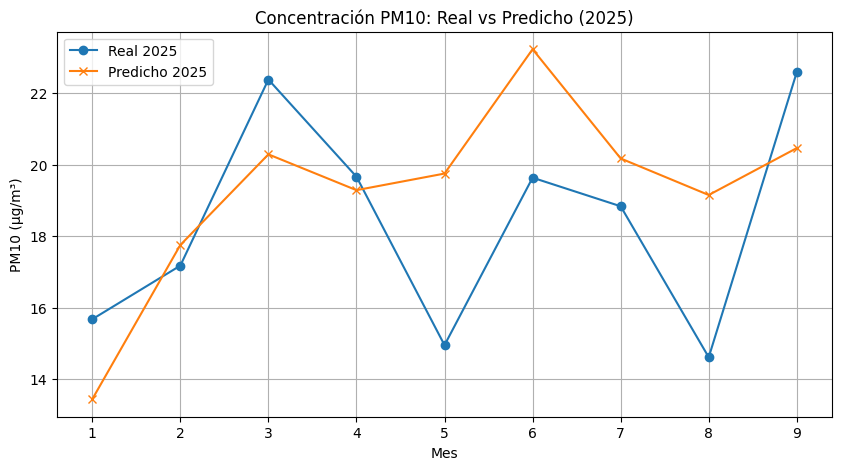

In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


df1 = pd.read_csv("/content/drive/MyDrive/pm102022.csv")
df2 = pd.read_csv("/content/drive/MyDrive/pm102023.csv")
df_union = pd.concat([df1, df2], ignore_index=True)


df_union["Date"] = pd.to_datetime(df_union["Date"], format="%m/%d/%Y", errors="coerce")
df_union["Year"] = df_union["Date"].dt.year
df_union["Month"] = df_union["Date"].dt.month


df_grouped = df_union.groupby(["Year", "Month"], as_index=False)["Daily Mean PM10 Concentration"].mean()


for year in df_grouped["Year"].unique():
    df_grouped[f"Year_{year}"] = (df_grouped["Year"] == year).astype(int)


for m in range(1, 13):
    df_grouped[f"Month_{str(m).zfill(2)}"] = (df_grouped["Month"] == m).astype(int)


X = df_grouped.drop(columns=["Year", "Month", "Daily Mean PM10 Concentration"])
y = df_grouped["Daily Mean PM10 Concentration"]


model = LinearRegression()
model.fit(X, y)


df3 = pd.read_csv("/content/drive/MyDrive/pm102025.csv")
df3["Date"] = pd.to_datetime(df3["Date"], format="%m/%d/%Y", errors="coerce")
df3["Year"] = df3["Date"].dt.year
df3["Month"] = df3["Date"].dt.month

df3_grouped = df3.groupby(["Year", "Month"], as_index=False)["Daily Mean PM10 Concentration"].mean()


for year in [2022, 2023, 2025]:
    df3_grouped[f"Year_{year}"] = (df3_grouped["Year"] == year).astype(int)

for m in range(1, 13):
    df3_grouped[f"Month_{str(m).zfill(2)}"] = (df3_grouped["Month"] == m).astype(int)


for col in X.columns:
    if col not in df3_grouped.columns:
        df3_grouped[col] = 0


df3_final = df3_grouped[["Daily Mean PM10 Concentration"] + list(X.columns)]


X_test = df3_final.drop(columns=["Daily Mean PM10 Concentration"])
y_test = df3_final["Daily Mean PM10 Concentration"]
y_pred = model.predict(X_test)


df_results = pd.DataFrame({
    "Month": df3_grouped["Month"],
    "Real_2025": y_test,
    "Predicho_2025": y_pred
})

print(df_results)


plt.figure(figsize=(10,5))
plt.plot(df_results["Month"], df_results["Real_2025"], marker="o", label="Real 2025")
plt.plot(df_results["Month"], df_results["Predicho_2025"], marker="x", label="Predicho 2025")
plt.xlabel("Mes")
plt.ylabel("PM10 (µg/m³)")
plt.title("Concentración PM10: Real vs Predicho (2025)")
plt.legend()
plt.grid(True)
plt.show()
